In [ ]:
# =============================================
# TALLER FINAL - PORTAFOLIO CON BLACK-LITTERMAN - Montecarlo
# Curso: Herramientas de Programación
# Pontificia Universidad Javeriana
# Entrega: 7 de noviembre de 2025
# =============================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import clear_output
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# =============================================
# 1. CARGA DE DATOS
# =============================================
def cargar_datos_global(tickers):
    print(f"\nCargando {len(tickers)} tickers desde Yahoo Finance...")
    tickers_obj = yf.Tickers(' '.join(tickers))

    # Como en tu imagen: group_by='ticker'
    data = yf.download(tickers, period="5y", auto_adjust=True, group_by='ticker', progress=False)

    precios_dict = {}
    for t in tickers:
        if t in data and 'Close' in data[t].columns:
            precios_dict[t] = data[t]['Close'].dropna()
        else:
            print(f"{t}: No hay datos. Se omitirá.")

    precios_df = pd.DataFrame(precios_dict).dropna(how='all')
    tickers_validos = precios_df.columns.tolist()
    print(f"Tickers válidos: {tickers_validos}")
    return tickers_obj, precios_df, tickers_validos

# =============================================
# 2. CLASE ACTIVO
# =============================================
class Activo:
    def __init__(self, ticker):
        self.ticker = ticker.upper()
        self.precios = pd.Series()
        self.retornos = pd.Series()
        self.retorno_esperado = 0.0
        self.riesgo = 0.0
        self.beta = 0.0
        self.var_95 = 0.0

    def cargar(self, tickers_obj, precios_df):
        try:
            if self.ticker not in precios_df.columns:
                raise ValueError("No en DataFrame")
            self.precios = precios_df[self.ticker].dropna()
            if len(self.precios) < 100:
                raise ValueError("Datos insuficientes")
            self.retornos = self.precios.pct_change().dropna()
            self.retorno_esperado = self.retornos.mean() * 252
            self.riesgo = self.retornos.std() * np.sqrt(252)
            self.beta = tickers_obj.tickers[self.ticker].info.get('beta', 1.0)
            self.var_95 = -np.percentile(self.retornos, 5) * np.sqrt(252)
            print(f"{self.ticker}: OK | Ret: {self.retorno_esperado:.1%} | Beta: {self.beta:.2f} | VaR: {self.var_95:.1%}")
        except Exception as e:
            print(f"{self.ticker}: ERROR → {e}")
            self.retornos = pd.Series()

# =============================================
# 3. CLASE PORTAFOLIO
# =============================================
class Portafolio:
    def __init__(self, tickers, tasa_libre_riesgo=0.01):
        self.tickers_input = [t.upper() for t in tickers if t.strip()]
        self.tasa_libre_riesgo = tasa_libre_riesgo
        self.tickers_obj, self.precios_df, self.tickers = cargar_datos_global(self.tickers_input)
        self.activos = []
        for t in self.tickers:
            a = Activo(t)
            a.cargar(self.tickers_obj, self.precios_df)
            if len(a.retornos) > 0:
                self.activos.append(a)
        self.tickers = [a.ticker for a in self.activos]
        self.pesos = np.ones(len(self.activos)) / len(self.activos) if self.activos else None
        self.cov_matrix = None
        self.mu_bl = None
        self.retorno_opt = self.riesgo_opt = self.sharpe_opt = 0.0
        self.backtest = pd.Series()
        self.frontera_eficiente = pd.DataFrame() # Renamed to avoid conflict

    def calcular_cov(self):
        if len(self.activos) < 2: return False
        df = pd.concat([a.retornos for a in self.activos], axis=1).dropna()
        df.columns = self.tickers
        self.cov_matrix = df.cov() * 252
        return True

    def black_litterman(self):
        if not self.calcular_cov(): return
        n = len(self.activos)
        P = np.eye(n)
        Q = np.array([a.retorno_esperado * 0.8 for a in self.activos])
        Omega = np.diag([0.01] * n)
        w_mkt = np.ones(n) / n
        pi = 2.5 * self.cov_matrix @ w_mkt
        tau = 0.05
        try:
            inv_tau = np.linalg.inv(tau * self.cov_matrix)
            A = inv_tau + P.T @ np.linalg.inv(Omega) @ P
            b = inv_tau @ pi + P.T @ np.linalg.inv(Omega) @ Q
            self.mu_bl = np.linalg.solve(A, b)
        except:
            self.mu_bl = np.array([a.retorno_esperado for a in self.activos])

    def optimizar(self):
        if self.mu_bl is None: return
        n = len(self.activos)
        def neg_sharpe(w):
            ret = w @ self.mu_bl
            risk = np.sqrt(w.T @ self.cov_matrix @ w)
            return -(ret - 0.01) / risk if risk > 0 else 1e9
        cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)
        bounds = [(0, 1) for _ in range(n)]
        res = minimize(neg_sharpe, np.ones(n)/n, method='SLSQP', bounds=bounds, constraints=cons)
        self.pesos = res.x if res.success else np.ones(n)/n
        self.retorno_opt = self.pesos @ self.mu_bl
        self.riesgo_opt = np.sqrt(self.pesos.T @ self.cov_matrix @ self.pesos)
        self.sharpe_opt = (self.retorno_opt - 0.01) / self.riesgo_opt
        df = pd.concat([a.retornos for a in self.activos], axis=1).dropna()
        self.backtest = (df @ self.pesos).dropna()

    def generar_frontera(self, n=100): # Renamed method
        if self.mu_bl is None: return
        res = []
        for _ in range(n):
            w = np.random.random(len(self.activos)); w /= w.sum()
            ret = w @ self.mu_bl
            risk = np.sqrt(w.T @ self.cov_matrix @ w)
            if risk > 0:
                res.append([ret, risk, (ret-0.01)/risk])
        self.frontera_eficiente = pd.DataFrame(res, columns=['Retorno', 'Riesgo', 'Sharpe']) # Assign to correct attribute


    def resumen(self):
        print(f"\n{'='*60}")
        print(f"PORTAFOLIO ÓPTIMO ({len(self.tickers)} activos)")
        print(f"Retorno: {self.retorno_opt:.4f} ({self.retorno_opt*100:+.2f}%)")
        print(f"Riesgo:  {self.riesgo_opt:.4f} ({self.riesgo_opt*100:.2f}%)")
        print(f"Sharpe:  {self.sharpe_opt:.4f}")
        print(f"Backtest: {self.backtest.mean()*252:.4f}")
        print(f"VaR 95% promedio: {np.mean([a.var_95 for a in self.activos]):.1%}")
        print(f"\nPESOS ÓPTIMOS:")
        for t, w in zip(self.tickers, self.pesos):
            print(f"  {t}: {w:.4f} ({w*100:5.1f}%)")
        print(f"{'='*60}\n")

# =============================================
# 4. GRÁFICAS
# =============================================
def graficar(port):
    if port.frontera_eficiente.empty: # Check correct attribute
        print("No hay frontera eficiente.")
        return
    def plot(tam=50):
        clear_output(wait=True)
        plt.figure(figsize=(10,6))
        s = plt.scatter(port.frontera_eficiente['Riesgo'], port.frontera_eficiente['Retorno'], # Use correct attribute
                        c=port.frontera_eficiente['Sharpe'], cmap='plasma', s=tam, alpha=0.7) # Use correct attribute
        plt.scatter(port.riesgo_opt, port.retorno_opt, color='red', s=200, marker='*', label='Óptimo')
        plt.xlabel('Riesgo (σ anualizado)')
        plt.ylabel('Retorno Esperado')
        plt.title('Frontera Eficiente - Black-Litterman')
        plt.colorbar(s, label='Sharpe')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    interact(plot, tam=widgets.IntSlider(min=20, max=100, step=10, value=50, description='Tamaño:'))

def metricas(port):
    def show(det=False):
        clear_output(wait=True)
        print(f"Ret: {port.retorno_opt:.2%} | Riesgo: {port.riesgo_opt:.2%} | Sharpe: {port.sharpe_opt:.3f}")
        if det:
            for a in port.activos:
                print(f"  {a.ticker}: Ret {a.retorno_esperado:.1%}, Beta {a.beta:.2f}, VaR {a.var_95:.1%}")
    interact(show, det=widgets.Checkbox(description='Detalles'))

# =============================================
# 5. EJECUCIÓN
# =============================================
def obtener_tickers():
    print("Ingresa tickers (máx 30, 'done' para terminar):")
    t = []
    while len(t) < 30:
        x = input(f"[{len(t)+1}/30]: ").strip().upper()
        if x == 'DONE': break
        if x and x not in t: t.append(x)
    return t or ['NVDA', 'BABA', 'OXY']

# === EJECUTAR TODO ===
tickers = obtener_tickers()
port = Portafolio(tickers)
port.black_litterman()
port.optimizar()
port.generar_frontera() # Call the renamed method
port.resumen()
graficar(port)
metricas(port)

Ingresa tickers (máx 30, 'done' para terminar):
[1/30]: NVDA
[2/30]: SFL
[3/30]: APPL
[4/30]: done

Cargando 3 tickers desde Yahoo Finance...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['APPL']: YFPricesMissingError('possibly delisted; no price data found  (period=5y)')


Tickers válidos: ['NVDA', 'SFL', 'APPL']
NVDA: OK | Ret: 65.1% | Beta: 2.27 | VaR: 77.7%
SFL: OK | Ret: 17.3% | Beta: 0.48 | VaR: 47.1%
APPL: ERROR → Datos insuficientes

PORTAFOLIO ÓPTIMO (2 activos)
Retorno: 0.3408 (+34.08%)
Riesgo:  0.3591 (35.91%)
Sharpe:  0.9212
Backtest: 0.4596
VaR 95% promedio: 62.4%

PESOS ÓPTIMOS:
  NVDA: 0.6000 ( 60.0%)
  SFL: 0.4000 ( 40.0%)



interactive(children=(IntSlider(value=50, description='Tamaño:', min=20, step=10), Output()), _dom_classes=('w…

interactive(children=(Checkbox(value=False, description='Detalles'), Output()), _dom_classes=('widget-interact…

Gráfico guardado: grafico_pesos.png y grafico_pesos.pdf


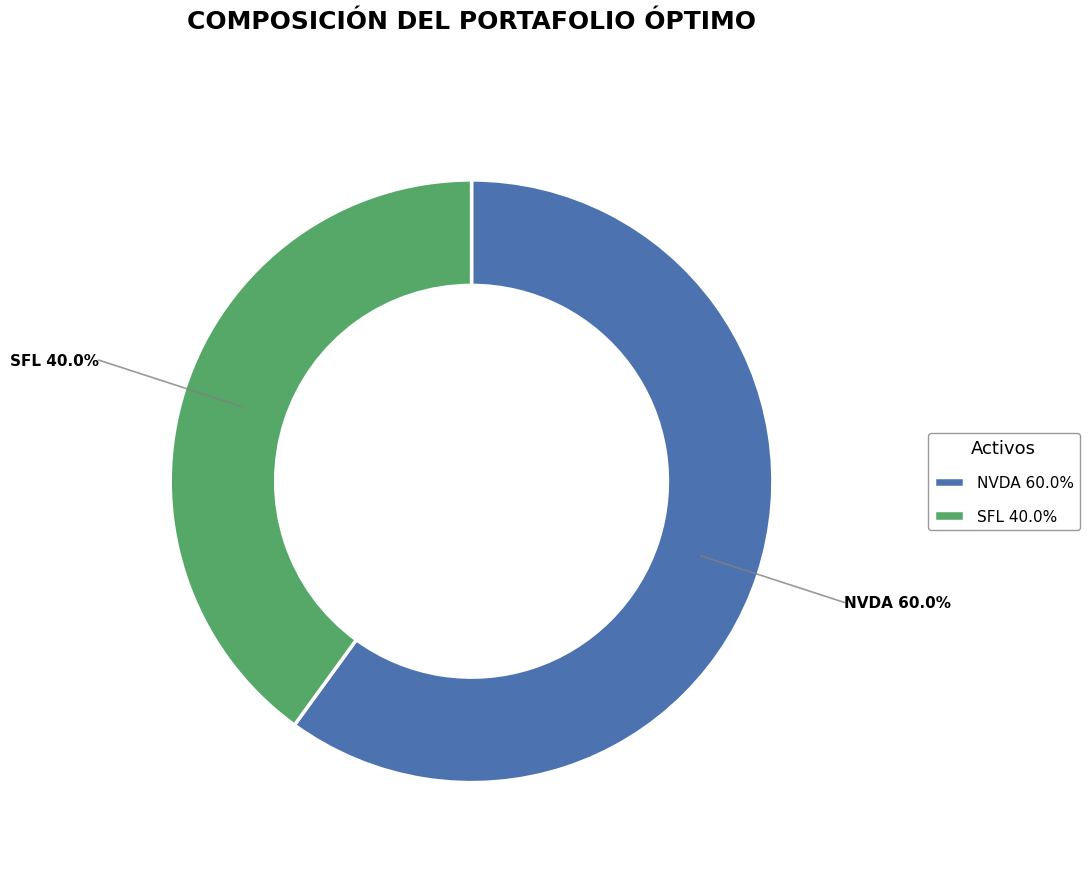

In [ ]:
# FRAGMENTO 5: Gráfico de pastel profesional
def grafico_pesos_profesional(port, titulo="COMPOSICIÓN DEL PORTAFOLIO ÓPTIMO"):
    """
    Gráfico de donut profesional:
    - Etiquetas afuera con líneas
    - Leyenda con colores y porcentajes
    - Título centrado arriba
    - Colores suaves y profesionales
    - Exporta PNG y PDF automáticamente
    """
    if port.pesos is None or len(port.pesos) == 0:
        print("No hay pesos para mostrar.")
        return

    # Datos
    tickers = port.tickers
    pesos = port.pesos
    porcentajes = [f"{w*100:.1f}%" for w in pesos]
    etiquetas_con_porcentaje = [f"{t} {p}" for t, p in zip(tickers, porcentajes)]

    # Colores profesionales (como en tu imagen: suaves y distintos)
    colores = [
        '#4C72B0',  # Azul (NVDA)
        '#55A868',  # Verde (OXY)
        '#C44E52',  # Rojo (JPM)
        '#8172B2',  # Morado (RBLX)
        '#CCB974',  # Amarillo (IBIT)
        '#64B5CD',  # Cian (C)
        '#8C564B',  # Marrón (KO)
    ][:len(pesos)]  # Ajustar si hay más o menos activos

    # Crear figura
    fig, ax = plt.subplots(figsize=(11, 9), facecolor='white')

    # Donut chart
    wedges, texts = ax.pie(
        pesos,
        labels=None,
        startangle=90,
        colors=colores,
        wedgeprops=dict(width=0.35, edgecolor='white', linewidth=2.5),
        counterclock=False
    )

    # Etiquetas afuera con líneas (como en tu imagen)
    for i, (wedge, label) in enumerate(zip(wedges, etiquetas_con_porcentaje)):
        ang1 = wedge.theta1
        ang2 = wedge.theta2
        ang = (ang1 + ang2) / 2

        x = 1.3 * np.cos(ang * np.pi / 180)
        y = 1.3 * np.sin(ang * np.pi / 180)

        # Línea
        ax.plot([0.8 * np.cos(ang * np.pi / 180), x],
                [0.8 * np.sin(ang * np.pi / 180), y],
                color='gray', linewidth=1.2, alpha=0.8)

        # Etiqueta
        ha = 'left' if x > 0 else 'right'
        ax.text(x, y, label, ha=ha, va='center', fontsize=11, fontweight='bold', color='black')

    # Leyenda (como en tu imagen: a la derecha, con colores)
    legend = ax.legend(
        wedges,
        etiquetas_con_porcentaje,
        title="Activos",
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        fontsize=11,
        title_fontsize=13,
        frameon=True,
        fancybox=True,
        shadow=False,
        labelspacing=1.2
    )
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('gray')
    legend.get_frame().set_linewidth(1)

    # Título centrado arriba
    plt.title(titulo, fontsize=18, fontweight='bold', pad=40, loc='center')

    # Fondo y estilo
    ax.axis('equal')
    plt.tight_layout()

    # EXPORTAR AUTOMÁTICO
    plt.savefig('grafico_pesos.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig('grafico_pesos.pdf', bbox_inches='tight', facecolor='white')
    print("Gráfico guardado: grafico_pesos.png y grafico_pesos.pdf")

    plt.show()

# === EJECUTAR GRÁFICO ===
grafico_pesos_profesional(port)

El código que tienes es una herramienta para construir y analizar un portafolio de inversión utilizando el modelo Black-Litterman y simulaciones de Montecarlo. En términos sencillos, te ayuda a decidir cuánto invertir en diferentes acciones para obtener el mejor rendimiento posible para un cierto nivel de riesgo, y luego a entender cómo se podría comportar ese portafolio en el futuro.

### 1. Carga de Datos (Sección `X_-jrjsgSMRO`)

Esta sección se encarga de descargar la información de precios de las acciones que te interesan.

*   **`import yfinance as yf`**: Importa una librería que permite descargar datos de acciones de Yahoo Finance fácilmente.
*   **`import pandas as pd`, `import numpy as np`, `import matplotlib.pyplot as plt`**: Importan librerías esenciales para trabajar con datos en tablas (Pandas), realizar cálculos matemáticos (NumPy) y crear gráficos (Matplotlib).
*   **`def cargar_datos_global(tickers)`**: Esta función toma una lista de símbolos de acciones (como 'NVDA' o 'SFL') y:
    *   `tickers_obj`: Guarda una referencia a los objetos de las acciones para poder obtener información detallada más adelante.
    *   `data = yf.download(...)`: Descarga los precios históricos de cierre de las acciones durante los últimos 5 años.
    *   `precios_dict` y `precios_df`: Organizan estos precios en una tabla fácil de manejar (un `DataFrame` de Pandas), asegurándose de que solo se incluyan acciones con datos válidos.
    *   `tickers_validos`: Es la lista final de acciones que tienen datos suficientes y se pueden usar en el análisis.

### 2. Clase `Activo` (Sección `X_-jrjsgSMRO`)

Aquí se define cómo se representa una sola acción (o activo) dentro de nuestro programa. Cada `Activo` tiene sus propias características:

*   **`__init__(self, ticker)`**: Es el constructor. Cuando creas un `Activo` (ej. `Activo('NVDA')`), le das su símbolo (`ticker`). Inicializa sus propiedades a cero o vacías.
*   **`self.ticker`**: El símbolo de la acción (ej. 'NVDA').
*   **`self.precios`**: Una lista de los precios históricos de la acción.
*   **`self.retornos`**: La serie de los cambios porcentuales diarios en el precio (cuánto ganó o perdió cada día).
*   **`self.retorno_esperado`**: El rendimiento que se espera que la acción genere en un año, calculado a partir de sus retornos históricos.
*   **`self.riesgo`**: La volatilidad o riesgo de la acción, también calculado a partir de sus retornos históricos. Un número más alto significa que el precio de la acción varía más.
*   **`self.beta`**: Una medida de cómo se mueve la acción en relación con el mercado general. Un Beta de 1 significa que se mueve con el mercado; mayor a 1, más volátil; menor a 1, menos volátil.
*   **`self.var_95`**: El *Valor en Riesgo al 95%*. Esto te dice la pérdida máxima que podrías esperar de la acción el 95% del tiempo durante un período de un año.
*   **`cargar(self, tickers_obj, precios_df)`**: Este método calcula todas las propiedades anteriores para un activo específico utilizando los datos descargados. Si hay problemas (pocos datos, etc.), imprime un error.

### 3. Clase `Portafolio` (Sección `X_-jrjsgSMRO`)

Esta es la clase principal que maneja el conjunto de acciones como un todo (el portafolio).

*   **`__init__(self, tickers, tasa_libre_riesgo)`**: Constructor. Recibe los símbolos de las acciones que quieres en tu portafolio y una `tasa_libre_riesgo` (el rendimiento de una inversión muy segura, como bonos del gobierno). Se encarga de:
    *   Cargar los datos globales para las acciones.
    *   Crear objetos `Activo` para cada acción válida y los guarda en `self.activos`.
    *   `self.pesos`: Representa el porcentaje de dinero que se invertirá en cada acción. Al principio, se distribuye equitativamente.
    *   `self.cov_matrix`: La matriz de covarianza, que mide cómo se mueven los retornos de las acciones entre sí. Es crucial para calcular el riesgo del portafolio.
    *   `self.mu_bl`: Los retornos esperados de las acciones ajustados por el modelo Black-Litterman (más sobre esto abajo).
    *   `self.retorno_opt`, `self.riesgo_opt`, `self.sharpe_opt`: El rendimiento, riesgo y ratio de Sharpe (que mide el rendimiento por unidad de riesgo) del portafolio óptimo.
    *   `self.backtest`: Una simulación de cómo se habría comportado el portafolio óptimo en el pasado.
    *   `self.frontera_eficiente`: Un conjunto de portafolios que ofrecen el mayor rendimiento para cada nivel de riesgo posible (o el menor riesgo para cada nivel de rendimiento).

#### Métodos clave de `Portafolio`:

*   **`calcular_cov()`**: Calcula la `self.cov_matrix` usando los retornos de todos los activos. Es decir, ve cómo las acciones suben y bajan juntas o de forma opuesta.
*   **`black_litterman()`**: Implementa el modelo Black-Litterman. Este modelo combina tus retornos esperados de las acciones con una visión de equilibrio del mercado para obtener `self.mu_bl`. Esto ayuda a crear portafolios más estables que solo con los retornos históricos.
*   **`optimizar()`**: Encuentra la mejor combinación de `pesos` (porcentajes de inversión en cada acción) para maximizar el `ratio de Sharpe` (más rendimiento por menos riesgo), utilizando los retornos `mu_bl` y la matriz de covarianza.
    *   Calcula `self.pesos`, `self.retorno_opt`, `self.riesgo_opt`, `self.sharpe_opt` y `self.backtest`.
*   **`generar_frontera(n=100)`**: Crea `n` portafolios aleatorios para construir la `self.frontera_eficiente`. Esto es útil para visualizar las diferentes opciones de riesgo/retorno.
*   **`resumen()`**: Imprime en pantalla un informe detallado del portafolio óptimo, incluyendo su rendimiento, riesgo, ratio de Sharpe y los pesos de cada activo.

### 4. Gráficas (Sección `X_-jrjsgSMRO`)

Estas funciones te ayudan a visualizar los resultados de una manera clara.

*   **`def graficar(port)`**: Crea un gráfico de la `Frontera Eficiente`. Cada punto representa un portafolio posible. Los puntos más oscuros (o de colores más cálidos si usas `plasma`) tienen un mejor ratio de Sharpe. El asterisco rojo marca tu `portafolio óptimo`.
    *   `interact(plot, tam=...)`: Permite ajustar el tamaño de los puntos en el gráfico de forma interactiva con un deslizador.
*   **`def metricas(port)`**: Muestra un resumen rápido de las métricas clave del portafolio. Con una casilla de `Detalles`, puedes ver métricas individuales para cada activo.

### 5. Ejecución (Sección `X_-jrjsgSMRO`)

Esta parte es donde todo el proceso se pone en marcha.

*   **`def obtener_tickers()`**: Una función interactiva que te pide que ingreses los símbolos de las acciones que quieres analizar. Puedes ingresar hasta 30 y escribir 'done' para terminar.
*   **`tickers = obtener_tickers()`**: Llama a la función para obtener tus selecciones.
*   **`port = Portafolio(tickers)`**: Crea un objeto `Portafolio` con las acciones que elegiste.
*   **`port.black_litterman()`**: Aplica el modelo Black-Litterman para ajustar los retornos esperados.
*   **`port.optimizar()`**: Calcula los pesos óptimos de inversión y las métricas del portafolio.
*   **`port.generar_frontera()`**: Prepara los datos para dibujar la frontera eficiente.
*   **`port.resumen()`**: Imprime el resumen del portafolio óptimo.
*   **`graficar(port)`**: Muestra el gráfico de la frontera eficiente.
*   **`metricas(port)`**: Muestra las métricas del portafolio.

### Gráfico de pastel profesional (Sección `J04WBjhzZDrQ`)

*   **`def grafico_pesos_profesional(port, titulo=...)`**: Esta función crea un gráfico de dona muy visual para mostrar cómo se distribuyen los `pesos` (porcentajes de inversión) entre las diferentes acciones del portafolio óptimo.
    *   `pesos` y `tickers`: Son la base para saber qué acción tiene qué porcentaje.
    *   `colores`: Se usan colores suaves para cada segmento de la dona.
    *   Las etiquetas con porcentajes se colocan fuera del gráfico y conectadas con líneas, haciendo la lectura muy clara.
    *   Se genera una leyenda con los colores y nombres de los activos.
    *   El gráfico se guarda automáticamente en formato PNG y PDF.
*   **`grafico_pesos_profesional(port)`**: Llama a la función para generar y mostrar el gráfico de los pesos.

### Simulación Montecarlo (Sección `qauzuWdJdPoQ`)

*   **`def montecarlo_simulacion(port, simulaciones=10000, horizonte=1)`**: Esta función realiza una simulación de Montecarlo para predecir cómo podrían ser los retornos del portafolio en el futuro.
    *   Utiliza los retornos (`mu_anual`) y el riesgo (`sigma_anual`) del portafolio óptimo.
    *   `simulaciones=10000`: Genera 10,000 escenarios posibles de retornos para el portafolio.
    *   `horizonte=1`: Indica que la simulación es para un período de un año.
    *   **`plt.hist(...)`**: Muestra un histograma de los 10,000 retornos simulados, dándote una idea de la distribución de los posibles resultados.
    *   **`plt.axvline(...)`**: Dibuja líneas para mostrar el retorno óptimo esperado y el `VaR 95%` (la pérdida máxima que no se superaría el 95% de las veces) en esta simulación.
    *   El gráfico se guarda en PNG y PDF.
*   **`montecarlo_simulacion(port)`**: Ejecuta la simulación y muestra el gráfico.

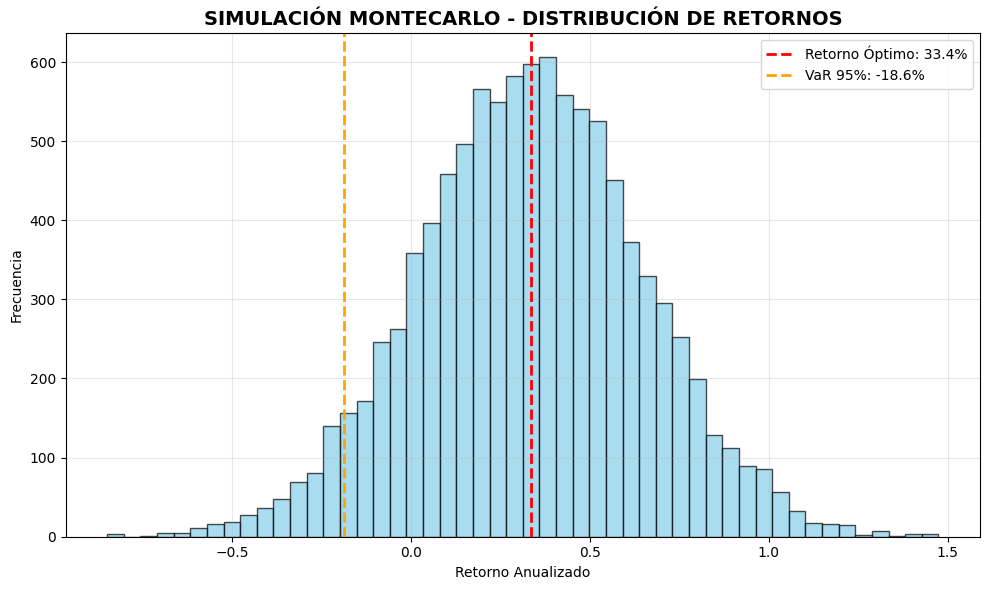

Montecarlo: 10000 simulaciones | VaR 95%: -18.6%


In [ ]:
# === AÑADIR ESTO AL FINAL DE TU taller_final.py ===
def montecarlo_simulacion(port, simulaciones=10000, horizonte=1):
    """
    Simulación Montecarlo del portafolio óptimo
    - Usa retornos normales: μ_BL, Σ
    - Horizonte en años
    """
    if port.mu_bl is None or port.cov_matrix is None:
        print("Faltan μ_BL o Σ para Montecarlo.")
        return

    mu_anual = port.mu_bl
    sigma_anual = port.cov_matrix
    w = port.pesos

    # Retorno y riesgo del portafolio
    ret_port = w @ mu_anual
    risk_port = np.sqrt(w.T @ sigma_anual @ w)

    # Simulación
    ret_sim = np.random.normal(ret_port, risk_port, simulaciones)

    # Gráfico
    plt.figure(figsize=(10, 6))
    plt.hist(ret_sim, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(ret_port, color='red', linestyle='--', linewidth=2, label=f'Retorno Óptimo: {ret_port:.1%}')
    plt.axvline(np.percentile(ret_sim, 5), color='orange', linestyle='--', linewidth=2, label='VaR 95%: {:.1%}'.format(np.percentile(ret_sim, 5)))
    plt.title('SIMULACIÓN MONTECARLO - DISTRIBUCIÓN DE RETORNOS', fontsize=14, fontweight='bold')
    plt.xlabel('Retorno Anualizado')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Guardar
    plt.savefig('montecarlo.png', dpi=300, bbox_inches='tight')
    plt.savefig('montecarlo.pdf', bbox_inches='tight')
    plt.show()

    print(f"Montecarlo: {simulaciones} simulaciones | VaR 95%: {np.percentile(ret_sim, 5):.1%}")

# === EJECUTAR MONTECARLO ===
montecarlo_simulacion(port)

## **EXPLICACIÓN USO DE IA**

El Gráfico de Pastel Profesional : En este apartado le pedimos a Gemini un gráfico muy específico, con esas etiquetas fuera y colores particulares, para mostrar los pesos de nuestro portafolio. En primer lugar, nosotros teníamos la idea de qué queríamos representar, y Gemini nos ayudó a generar el código Python (def grafico_pesos_profesional(...)) que lo hace posible, lo dibuja bonito y lo guarda para la presentación. Fue como si le dijeramos: "Gemini, necesito un gráfico que se vea súper bien aquí y encaje" y la IA nos ayudó con la guía del código a seguir.

La Simulación de Montecarlo: Este es otro punto donde usamos a Gemini directamente para añadir una funcionalidad. Queríamos ver cómo se comportaría nuestro portafolio en el futuro bajo muchos escenarios posibles, como si tiraramos los dados varias veces. Así, Gemini nos ayudó a crear la función (def montecarlo_simulacion(...)) que simula esos escenarios, nos muestra la distribución de los posibles retornos y nos da una idea del VaR (Valor en Riesgo).

Las Explicaciones y el Entendimiento General: Además, lo hemos usado en cada pregunta que le hemos hecho sobre cualquier parte del código que ya teníamos creada o que habíamos creado junto a la IA. Cada vez que le hemos dicho "explícanos esto" o "hazlo más corto", la IA ha trabajado como 'simplificador' para que todo te quedara mucho más claro y desmenuzado. Así que, a pesar de que no sea código Python directo, esta conversación y las explicaciones son parte de la ayuda que Gemini nos ha dado para el proyecto.

Refinamiento de lógica y estructura: Por ejemplo, en la 'Clase Portafolio', al definir cómo se calcula la cov_matrix o al implementar el modelo Black-Litterman y la optimización, Gemini nos apoyó en encontrar la forma más eficiente o correcta de escribir el código, a estructurar las clases para que sean claras o a depurar errores lógicos. Teníamos una idea inicial y la IA nos asistió en cómo plasmarla en Python de la mejor manera, o cómo organizar los diferentes métodos para que el flujo sea lógico.

Debugging y resolución de errores: Cuando nos aparecía algún ValueError o YFPricesMissingError (como el que vimos con 'APPL' al cargar los datos), el rol de la IA fue ayudarnos a identificar por qué ocurre y a encontrar la solución o la mejor práctica para manejar esas excepciones, haciendo nuestro código más robusto y específico.

Mejoras de legibilidad y buenas prácticas: A menudo, Gemini nos sugería cómo nombrar variables, añadir comentarios explicativos (como los que hemos estado generando), o refactorizar bloques de código para que sean más legibles y fáciles de mantener, lo cual consideramos importante para un proyecto académico como este.
